In [1]:
import csv
from pathlib import Path
import sys

SD_DIR = Path('/Users/penguin/Documents/Grad School/Research/XSM/XSM-Analysis/multiflarefit2')
DATA_DIR = Path('../data')

sys.path.append(str(SD_DIR))        # Add SuryaDrishti path to runtime executable (does not 
                                    # change global Python PATHS)

In [2]:
import pandas as pd
import numpy as np
from numpy.core._exceptions import UFuncTypeError
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy.optimize import curve_fit

from utils import get_flare_class, get_snr      # From SuryaDrishti
from morph import *

np.set_printoptions(suppress=True)

In [3]:
filtered_flares = pd.read_csv(DATA_DIR / 'allflares_preprocessed.csv')      # Read output data format from real data run

print(filtered_flares.keys())                                               # Print data field keys
print()

# Select few important rows to simulate
# discrepancy_flag = 1 indicates misclassification after adding noise
columns = ['identifier', 'peak_count', 'flare_class', 'background_slope', 'background_intercept', 'amplitude', 'mu', 'sigma', 'tau', 'sigma-by-tau', 'snr', 'flare_type', 'discrepancy_flag']

# Print median values of parametric model fit parameters
print(filtered_flares[['peak_count', 'amplitude', 'sigma', 'tau', 'background']].median())
print()

# Pretty print
filtered_flares[['peak_count', 'flare_class', 'amplitude', 'sigma', 'tau', 'background', 'flare_type']][:10]

Index(['date', 'identifier', 'start_time', 'start_count', 'peak_time',
       'peak_count', 'end_time', 'end_count', 'scpeaks0-05',
       'multi_flare_region_flag', 'region_resolved_flag', 'flare_class',
       'background', 'amplitude', 'mu', 'sigma', 'tau', 'redchisq', 'rsquared',
       'snr', 'fluence', 'sigma-by-tau', 'flare_type', 'duration'],
      dtype='object')

peak_count     49.23
amplitude     127.69
sigma         135.16
tau           287.74
background    158.70
dtype: float64



,peak_count,flare_class,amplitude,sigma,tau,background,flare_type
0,101.03,B1,311.52,61.21,329.99,486.17,B
1,42.79,A4,43.39,147.99,25.00,414.51,A
2,507.60,B5,2114.62,175.50,1230.74,434.21,B
3,103.02,B1,513.42,364.05,3518.37,326.08,B
4,20.66,A2,20.89,357.32,54.72,326.08,F
5,797.72,B7,2834.86,38.63,252.30,321.35,B
6,137.88,B1,414.99,481.85,2512.16,321.35,B
7,96.99,A9,1295.65,99.06,3043.35,391.40,B
8,444.71,B4,469.62,3362.39,1141.86,0.00,A
9,28.07,A2,28.59,199.60,39.31,446.31,A


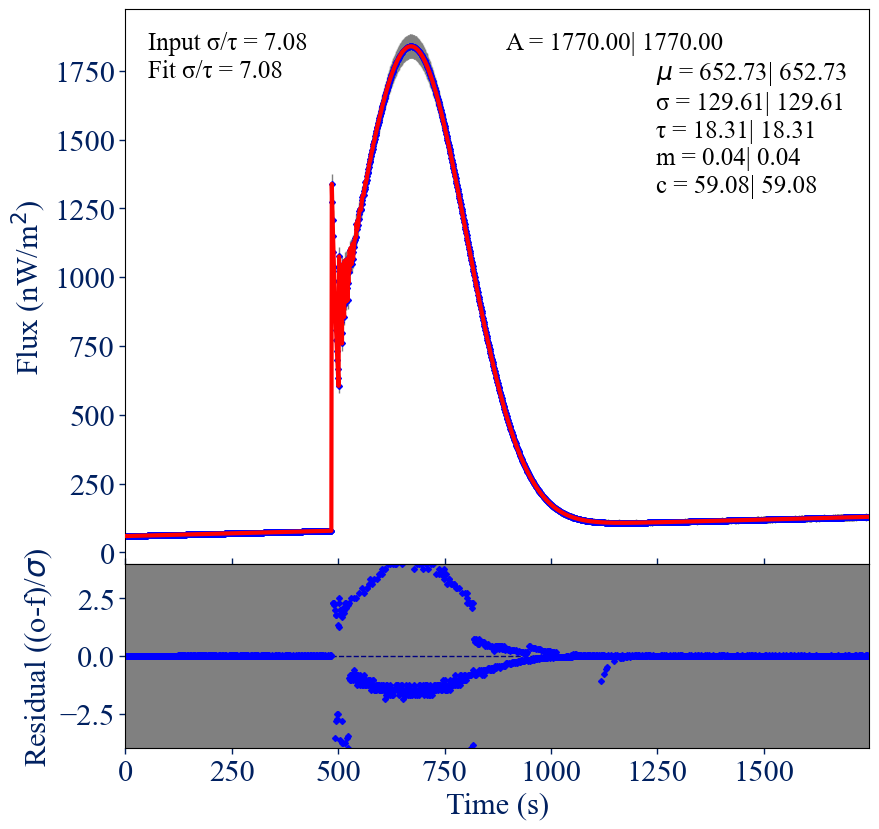

In [4]:
np.seterr(all='raise')

n = 1750

A = 1770
mu = 652.73
sigma = 129.61
tau = 18.31
m = 0.04
c = 59.08

xdata = np.arange(n, dtype='g')
inputparams = np.array([A, mu, sigma, tau, m, c], dtype=np.longdouble)

ydata, yerr = sim_data(xdata, inputparams, noisefree=True)

popt, fig = plot_flare(xdata, ydata, yerr, inputparams, plot=True)

In [5]:
# Fraction of type B and A in simulation
fracTypeB = 0.5
fracTypeA = 1 - fracTypeB

# Modelling the type A-B curve (see full simulation methods used below)
bins_sigmabytau = np.logspace(-3, 2, 101)

yB = 10**(np.random.normal(np.log10(np.sqrt(10)/10), np.log10(10)/2.35, int(fracTypeB * 20000)))
yA = 10**(np.random.normal(np.log10(4), np.log10(2)/2.35, int(fracTypeA * 20000)))

countsB, _ = np.histogram(yB, bins=bins_sigmabytau)
countsA, _ = np.histogram(yA, bins=bins_sigmabytau)

In [19]:
# Simulation runtime parameters
runs = 10000
noisefree_flag = False
get_plot_flag = False
save_plot_flag = False       # get_plot_flag must be also be True if you want to save a plot

simnum = 6
filepath = DATA_DIR / Path(f'simulated/sim{simnum}/')
# if (filepath / 'flares/0.csv').is_file():
#     raise FileExistsError("Check if filepath already has another simulation")

# Initialize runtime logging parameters
count_mis = 0
count_runs = runs
fit_sigmabytau = []
flare_sim_list = []
flare_fit_list = []

# Create sigmabytau sample from distribution
sigmabytau = np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB), size=runs)
# for i in range(runs):
#     while 1.7 < sigmabytau[i] < 3.2:
#         sigmabytau[i] = np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB))

# Start simulating
for i in range(runs):
    discrepancy_flag = 0

    # Sample from priors
    n = np.random.randint(800, 2000)
    # n = np.int32(1000 * 10 ** (np.random.normal(0, 0.42)))

    A = 50 * 10 ** (np.random.uniform(1, 2))
    mu = 0.4 * n + np.random.uniform(-100, 100) #np.random.uniform(300,500)
    tau = 350 * 10 ** (np.random.normal(0, 0.5))
    sigma = sigmabytau[i] * tau         
    while sigma > 500:              # There are some flares with sigma ~800 which are just long duration. TODO: Improve this prior
        tau = 350 * 10 ** (np.random.normal(0, 0.5))
        sigma = sigmabytau[i] * tau

    m = np.random.uniform(-0.15, 0.15)
    c = np.abs(min(n*m, 0)) + 100 * 10 ** np.random.normal(0, 0.5)

    xdata = np.arange(n)
    inputparams = np.array([A, mu, sigma, tau, m, c])

    ydata, yerr = sim_data(xdata, inputparams, noisefree=noisefree_flag)
    if type(ydata) == str:
        count_runs -= 1     # This run was not accounted for
        print('back in loop. yval returned error.')
        continue

    # Attempt simulation
    try:
        # popt, pcov = plot_flare(xdata, ydata, yerr, inputparams)
        popt, fig = plot_flare(xdata, ydata, yerr, inputparams, plot=get_plot_flag)
    except (RuntimeError, FloatingPointError, UFuncTypeError):
        count_runs -= 1     # This run was not accounted for
        continue

    fit_sigmabytau.append(popt[2]/popt[3])
    # If fit_sigmabytau lies in window, skip flare.
    if 1.7 < fit_sigmabytau[-1] < 3.0:
        fit_sigmabytau.pop()
        count_runs -= 1     # This run was not accounted for
        continue

    # Override input if sigma/tau of data and fit don't match
    sim_flare_type = get_flare_type(inputparams[2], inputparams[3])
    fit_flare_type = get_flare_type(popt[2], popt[3])
    if sim_flare_type != fit_flare_type:
        discrepancy_flag = 1      # Misclassification due to fitting
        count_mis += 1

    if save_plot_flag:
        plt.savefig(filepath / f'plots/{i}.png')
        plt.close()

    # Data packaging
    sim_background = m * xdata + c
    sim_signal = exp_gaus_single(xdata, *inputparams) - sim_background
    sim_peak_count = np.max(sim_signal)

    fit_background = popt[4] * xdata + popt[5]
    fit_signal = exp_gaus_single(xdata, *popt) - fit_background
    fit_peak_count = np.max(fit_signal)

    try:
        flare_sim_list.append([i, sim_peak_count, get_flare_class(sim_peak_count), m, c, A, mu, sigma, tau, sigma/tau, np.sum(get_snr(sim_signal, sim_background)), sim_flare_type, discrepancy_flag])
        flare_fit_list.append([i, fit_peak_count, get_flare_class(fit_peak_count), popt[4], popt[5], popt[0], popt[1], popt[2], popt[3], fit_sigmabytau[-1], np.sum(get_snr(fit_signal, fit_background)), fit_flare_type, discrepancy_flag])
    except:
        flare_sim_list.append([i, sim_peak_count, 'U0', m, c, A, mu, sigma, tau, sigma/tau, -1, sim_flare_type, discrepancy_flag])
        flare_fit_list.append([i, fit_peak_count, 'U0', popt[4], popt[5], popt[0], popt[1], popt[2], popt[3], fit_sigmabytau[-1], -1, fit_flare_type, discrepancy_flag])     

    # Save light curve
    filename = filepath / f'flares/{i}.csv'
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["Time", "Counts", "Error"])
        writer.writerows(np.vstack([xdata, ydata, yerr]).T)

print(count_mis / count_runs)

overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp


/Users/penguin/miniconda3/envs/xsm/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
0.03832033042680129


In [20]:
pd.DataFrame(flare_fit_list, columns=columns).to_csv(filepath / 'fitted_flares.csv')
pd.DataFrame(flare_sim_list, columns=columns).to_csv(filepath / 'simulated_flares.csv')

### Plotting the sigma/tau sample
Input simulation vs Curve-fit of noisy data

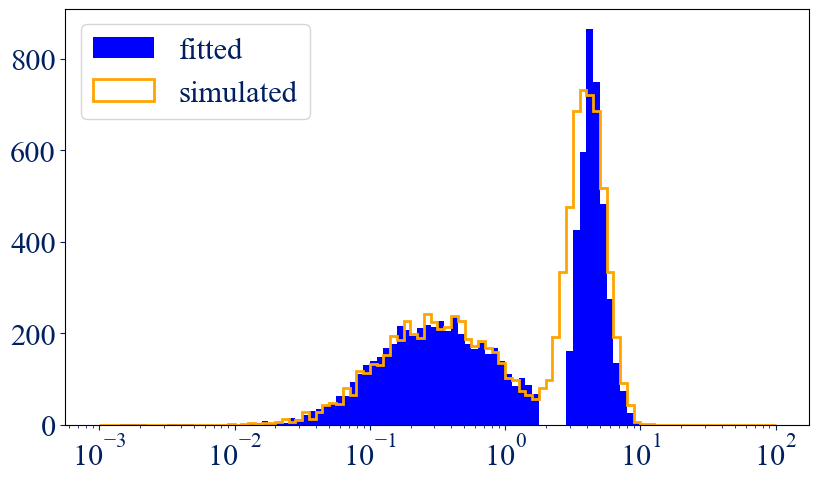

In [21]:
plt.hist(fit_sigmabytau, bins=bins_sigmabytau, label='fitted')
plt.hist(sigmabytau, bins=bins_sigmabytau, histtype='step', lw=2, edgecolor='orange', label='simulated')
plt.xscale('log')
plt.legend()
plt.show()

In [87]:
(inputparams - popt) / inputparams

array([ 0.03307833, -0.03559546, -0.0226029 ,  0.5535872 , -0.00045928,
        0.00001665])

### Amplitude, Sigma and Tau Priors

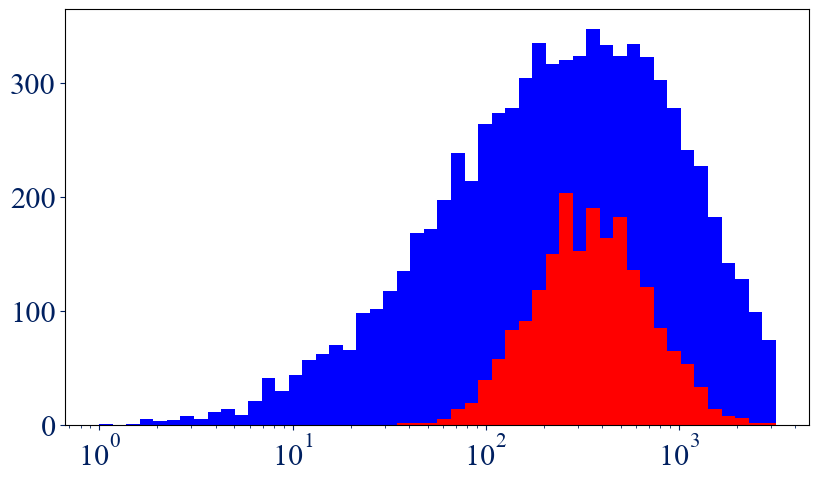

In [ ]:
plt.hist(filtered_flares['tau'], bins=np.logspace(0,3.5,51))
plt.hist(350 * 10 ** (np.random.normal(0, 0.3, 2000)), bins=np.logspace(0,3.5,51))        # for tau
plt.xscale('log')

In [454]:
filtered_flares[filtered_flares['sigma'] > 300]

,date,identifier,start_time,start_count,peak_time,peak_count,end_time,end_count,scpeaks0-05,multi_flare_region_flag,...,mu,sigma,tau,redchisq,rsquared,snr,fluence,sigma-by-tau,flare_type,duration
3,20221104,20221104ao,72505.0,10.25,73475.0,103.02,75295.0,70.03,6,True,...,73015.00,364.05,3518.37,189.323,0.822,292.76,7879.08,0.103471,B,2790.0
4,20221104,20221104an,71875.0,0.00,74915.0,20.66,75295.0,11.98,6,True,...,74863.92,357.32,54.72,189.323,0.248,19.31,532.73,6.529971,F,3420.0
6,20221104,20221104am,64975.0,35.54,66105.0,137.88,69445.0,40.37,2,True,...,65385.00,481.85,2512.16,316.959,0.810,881.03,23972.47,0.191807,B,4470.0
8,20221104,20221104aj,58735.0,432.06,59275.0,444.71,61255.0,403.97,3,False,...,58615.00,3362.39,1141.86,106.261,0.708,2342.16,48569.32,2.944660,A,2520.0
10,20221104,20221104ah,51175.0,97.04,52175.0,157.67,54295.0,71.75,6,False,...,51345.00,820.44,1898.60,143.020,0.868,738.77,20059.99,0.432129,B,3120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,20191002,20191002ac,43235.0,0.30,44145.0,2.96,45255.0,0.29,32,False,...,43917.53,391.14,292.94,0.665,0.598,106.08,326.33,1.335222,B,2020.0
8021,20191001,20191001ag,24805.0,0.49,25475.0,4.90,26155.0,0.49,34,True,...,25404.66,305.90,74.07,0.744,0.738,133.96,383.07,4.129877,A,1350.0
8023,20191001,20191001ae,10615.0,12.93,12325.0,56.89,15185.0,5.67,33,False,...,11709.20,879.05,874.03,7.538,0.982,2115.15,14975.11,1.005744,B,4570.0
8026,20190930,20190930am,78125.0,0.93,78975.0,9.29,79845.0,0.92,22,True,...,78890.25,390.10,91.85,1.841,0.848,206.05,898.94,4.247142,A,1720.0


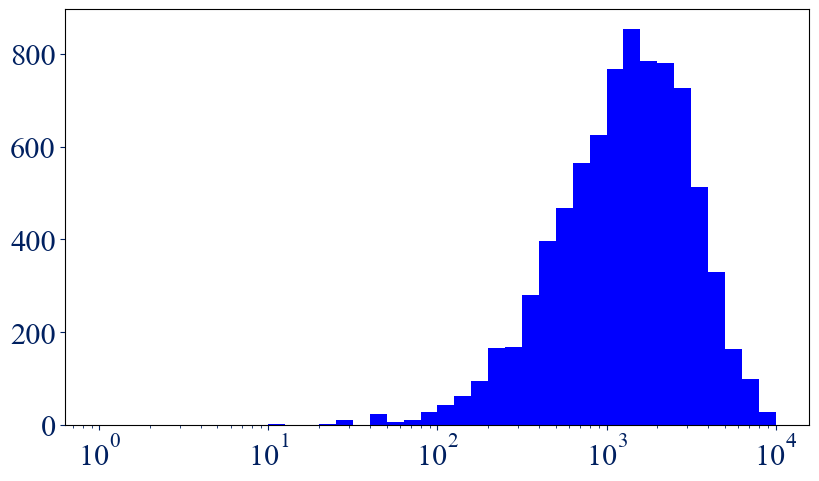

In [462]:
filtered_flares['duration'].median(), filtered_flares['duration'].mean()
plt.hist(filtered_flares['duration'], bins=np.logspace(0,4,41))
plt.xscale('log')
plt.show()

### Modelling the type A-B curve

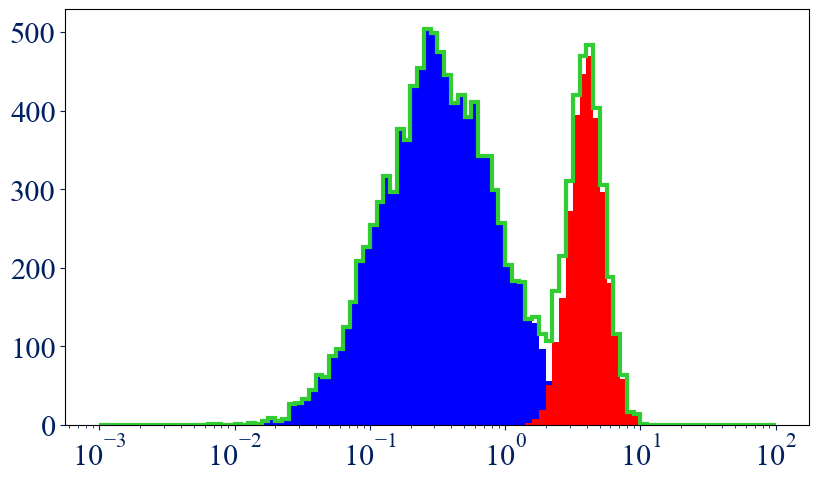

In [ ]:
# Modelling the type A-B curve
bins_sigmabytau = np.logspace(-3, 2, 101)

yB = 10**(np.random.normal(np.log10(np.sqrt(10)/10), np.log10(10)/2.35, 10000))
yA = 10**(np.random.normal(np.log10(4), np.log10(2)/2.35, 3000))

countsB, _, _ = plt.hist(yB, bins=bins_sigmabytau)
countsA, _, _ = plt.hist(yA, bins=bins_sigmabytau)
# plt.close()
plt.stairs(countsA+countsB, bins_sigmabytau, lw=3)
plt.xscale('log')
plt.show()

In [ ]:
np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB))   # Sample from above type A-B curve model

0.31622776601683794

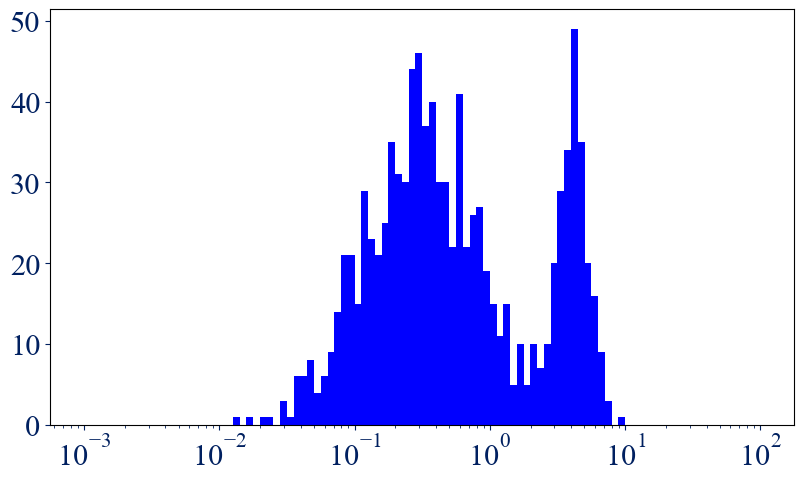

In [ ]:
# Random sampling from type A-B curve with appropriate weighting
plt.hist(np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB), size=1000), bins=bins_sigmabytau)
plt.xscale('log')
plt.show()

In [ ]:
# Calculating area under curve in window
cond1 = bins_sigmabytau > 1
cond2 = bins_sigmabytau < 3
window = cond1 & cond2

np.argwhere(window)

array([[61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69]])

In [ ]:
# Bin edge values for window part of the type A-B curve
bins_sigmabytau[window == True]

array([1.12201845, 1.25892541, 1.41253754, 1.58489319, 1.77827941,
       1.99526231, 2.23872114, 2.51188643, 2.81838293])

In [ ]:
# Area under window part of the type A-B curve
np.sum(((countsA+countsB)/np.sum(countsA+countsB))[window[:-1]])

0.11961538461538462